# Notebook #1: HyperplaneTree Regression Tutorial and Example

This notebook is part of the Supporting Information of the paper "Hyperplane Decision Trees as Piecewise Linear Surrogate Models for Chemical Process Design", by Sunshine et al.

Welcome to this tutorial and example notebook for Hyperplane-Tree. [hyperplanetree](https://github.com/LLNL/systems2atoms/tree/add-hyperplanetree/systems2atoms/hyperplanetree) is a Python package that can be used to build piecewise linear regression models. These models can be used in global optimization problems.

The main purpose of this notebook is to introduce the regression models in the package. Italso discusses a few hyperparameters which can be tuned to help improve accuracy, reduce model complexity, and accelerate the fitting process.

Aditionally, for completeness, we also show how to embed the surrogate obtained with the package into an optimization problem in [pyomo](https://www.pyomo.org/) using [OMLT](https://omlt.readthedocs.io/en/latest/).

Contact the authors of the paper if you have any questions.

## Install the package from github

In [ ]:
!pip install git+https://github.com/LLNL/systems2atoms

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import pandas as pd
import torch 
import sklearn
import time
from IPython.display import display, HTML
import base64
import io
from sklearn.model_selection import train_test_split
from mpl_toolkits.mplot3d import Axes3D
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error
import lineartree
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from systems2atoms.hyperplanetree import LinearTreeRegressor, HyperplaneTreeRegressor, plot_surrogate_2d
from tqdm.auto import tqdm


plt.rcParams['figure.dpi'] = 200
torch_device = 'cpu'

## Setup Regression Problem

First we need to set up an example non-linear regression problem. In this example, we will use a nonlinear function to generate data. This data will then be divided into train and test splits. Some noise is also added.

It is not immediately obvious what type of model architecture will best fit this function. As you will see, piecewise linear models can easily be trained to fit this function very well.

Train indices: [14307 17812 11020 ... 38158   860 15795] (32000 points)
Test indices: [32823 16298 28505 ... 16359  3842 37682] (8000 points)


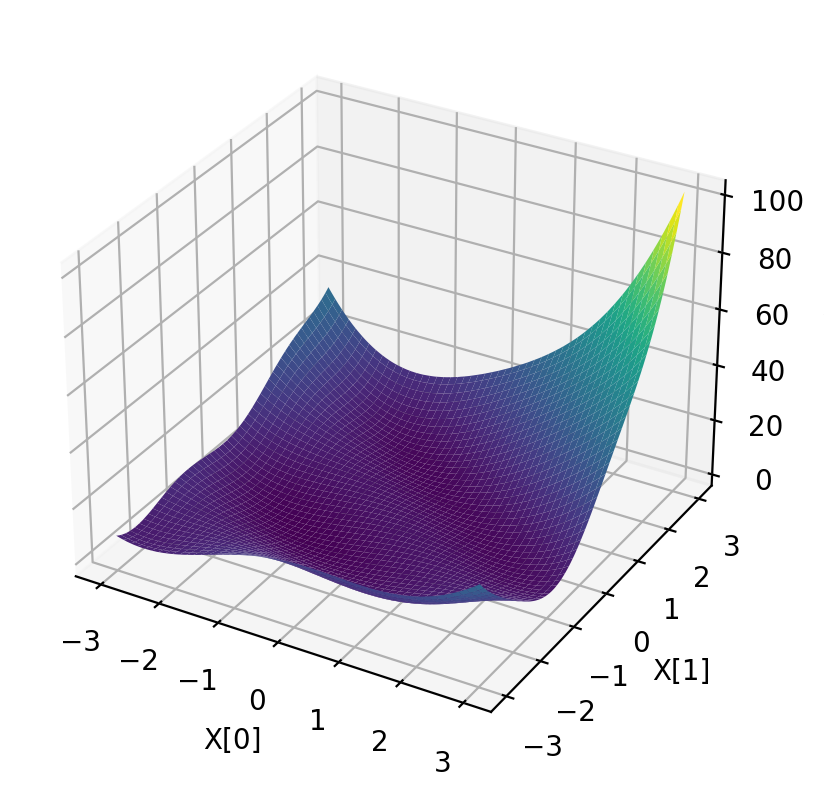

In [3]:
def generate_function(x, y, noise_scale=0.01):
    'This function generates a "synthetic" function with some noise, merely to serve as example.'
    a = (x - 0.5) / 1.5 + (y + 0.5)  
    term1 = a * x * y  
    term2 = a**2  
    term3 = 3 * torch.cos(2 * a) 
    term4 = 0.2 * (x - 0.5)**2 * (y + 0.5)**2 

    # The following terms discourage having the minimum at one of the edges
    term5 = 0.1 * (x**4)  
    term6 = 0.1 * (y**4)  

    f = term1 + term2 + term3 + term4 + term5 + term6

    # Add Gaussian noise
    f += torch.normal(mean=torch.zeros_like(x), std=noise_scale)

    return f.to(torch_device)

# Generate sampling points
x0 = torch.linspace(-3, 3, 200, device=torch_device)
x1 = torch.linspace(-3, 3, 200, device=torch_device)
X0, X1 = torch.meshgrid(x0, x1, indexing='ij')

# Generate data using the function
y = generate_function(X0, X1, noise_scale=0.01).type(torch.float).flatten()

# Generate features and labels tensors
features = torch.vstack((X0.flatten(), X1.flatten())).T.type(torch.float)

indices = np.arange(len(features))

# Splitting the data into train and test sets
# 20% of the data will be used for test, and 42 is used as the seed for random state, for reproducibility
train_features, test_features, train_y, test_y, train_indices, test_indices = train_test_split(
    features, y, indices, test_size=0.2, random_state=42
)

# Making sure we have shuffled indices and correct splits
print(f'Train indices: {train_indices} ({np.size(train_indices)} points)')
print(f'Test indices: {test_indices} ({np.size(test_indices)} points)')

# Plot the function
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X0.cpu(), X1.cpu(), y.reshape(X0.shape).cpu(), cmap='viridis')

ax.set_xlabel('X[0]')
ax.set_ylabel('X[1]')
ax.set_zlabel('y')

plt.show()

fig.savefig("original_function_example.png", dpi=300, format='png')



## Training different types of decision tree models

### Traditional decision trees

The first model we will train is a regular decision tree model using the [scikit-learn](https://scikit-learn.org/stable/), in which each leaf corresponds to a constant value. 

In [4]:
# Performing a grid search to find the best set of hyperparameters for this decision tree
param_grid = {
    'max_depth': [10, 15, 20],
    'min_samples_split': [10, 20, 30],
    'min_samples_leaf': [5, 10, 15],
    'ccp_alpha': [0.01, 0.05, 0.1, 0.2]
}

grid_search = GridSearchCV(
    DecisionTreeRegressor(random_state=42),
    param_grid,
    cv=5,
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    # verbose=2
)

grid_search.fit(train_features, train_y)

best_model = grid_search.best_estimator_
print(f"Best Parameters with constrained search: {grid_search.best_params_}")

# Evaluate the best model within the grid search
train_predictions = best_model.predict(train_features)
test_predictions = best_model.predict(test_features)

train_mae = mean_absolute_error(train_y, train_predictions)
test_mae = mean_absolute_error(test_y, test_predictions)

print(f"Train MAE: {train_mae:.3f}")
print(f"Test MAE: {test_mae:.3f}")

num_leaves = best_model.get_n_leaves()
tree_depth = best_model.get_depth()

print(f"Number of leaves in the  model: {num_leaves}")
print(f"Depth of the model: {tree_depth}")


Best Parameters with constrained search: {'ccp_alpha': 0.01, 'max_depth': 15, 'min_samples_leaf': 5, 'min_samples_split': 10}
Train MAE: 1.007
Test MAE: 1.077
Number of leaves in the  model: 198
Depth of the model: 15


We can see the MAE is somewhat low and the train and test errors are not very different, so we will proceed with the model. Below is a plot of how the predictions based on the model.

In [5]:
model_dt = DecisionTreeRegressor(random_state=42,
**grid_search.best_params_
)

t1 = time.time()
model_dt.fit(train_features, train_y)
t2 = time.time()

y_pred = model_dt.predict(test_features)

dt_error = mean_absolute_error(y_pred, test_y)

num_leaves_dt = model_dt.get_n_leaves()
dt_time = t2 - t1

print(f'Model                  # Leaves      Error (MAE)    Training time (s)')
print(f'Decision Tree:           {num_leaves_dt}            {dt_error:.3f}          {dt_time:.2f}')


Model                  # Leaves      Error (MAE)    Training time (s)
Decision Tree:           198            1.077          0.05


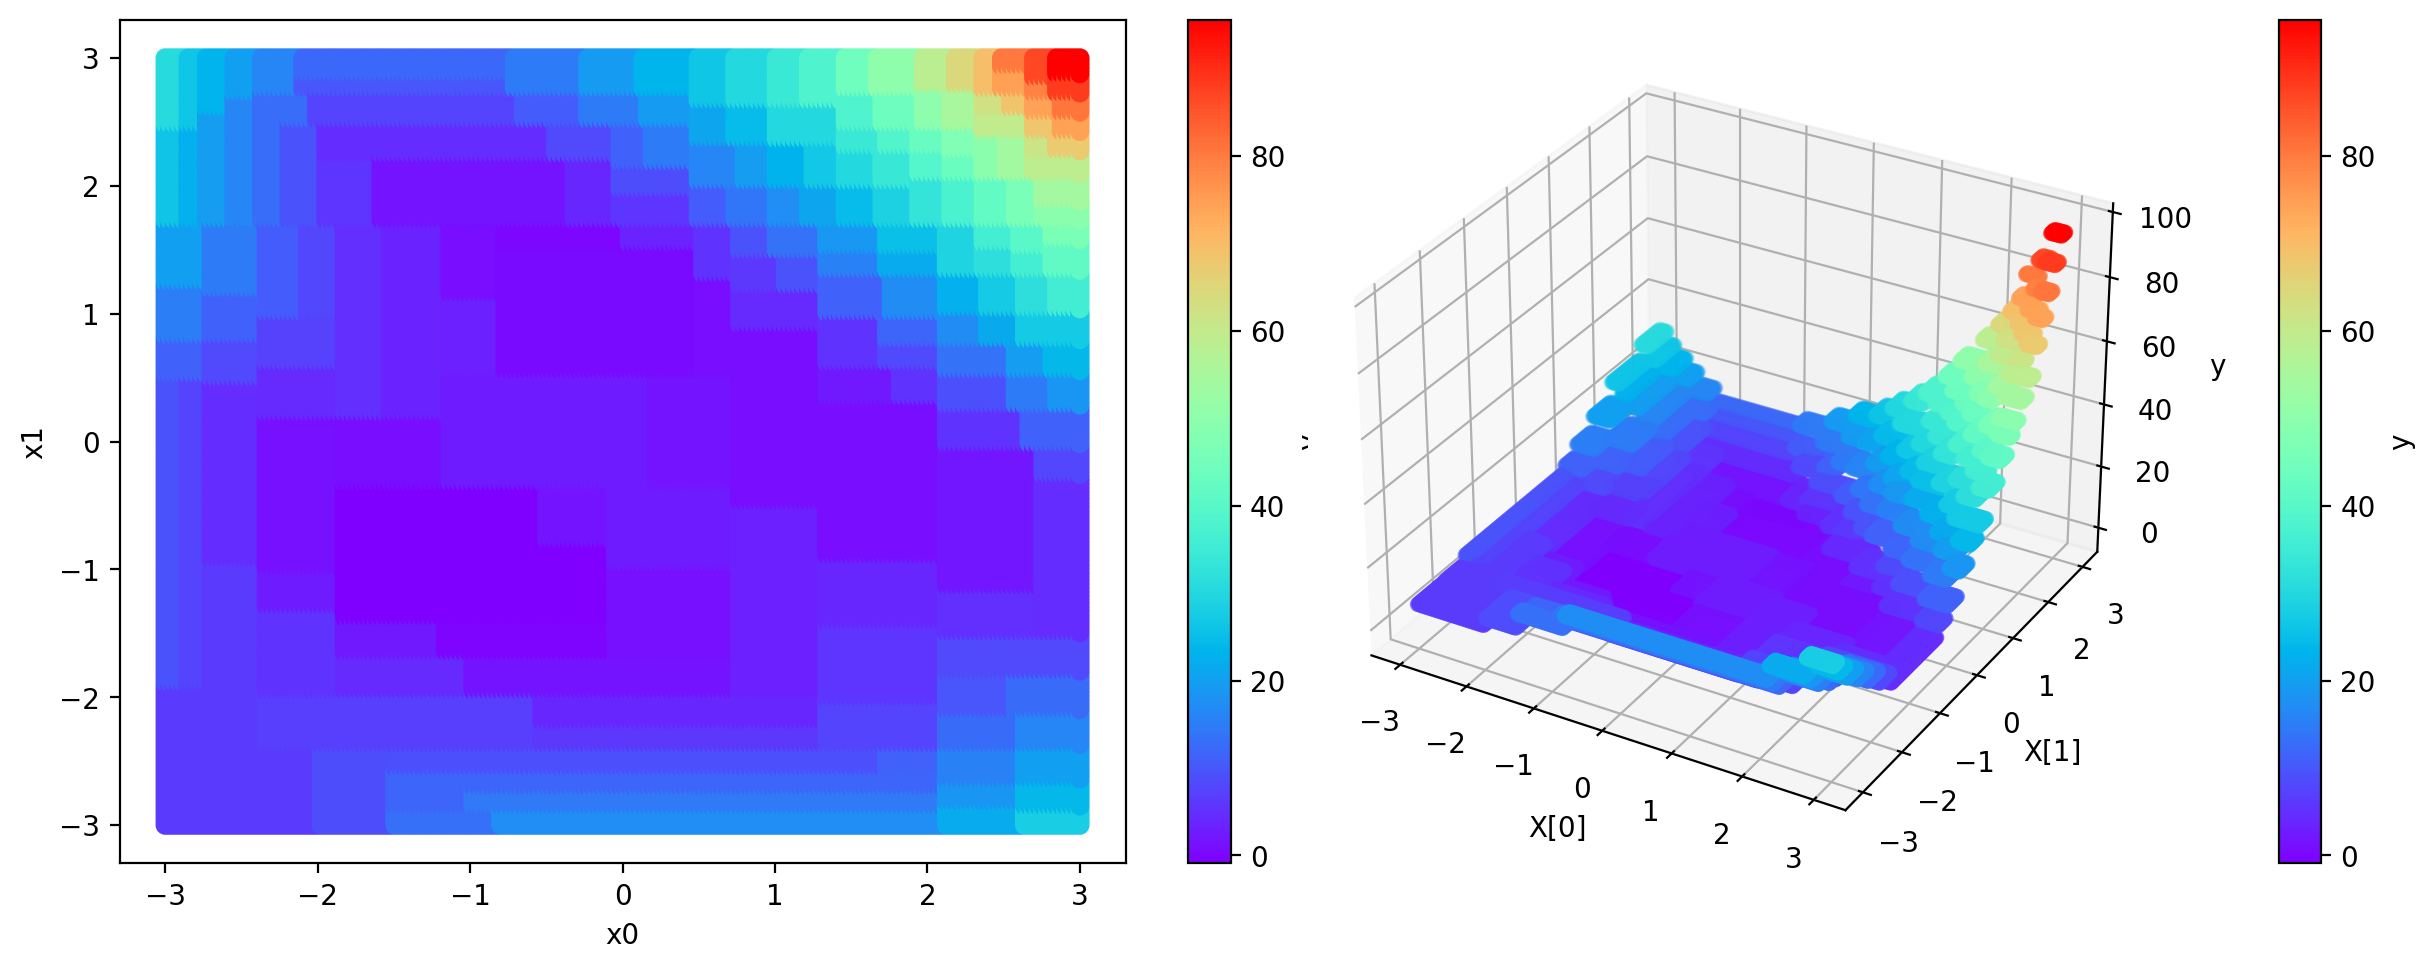

In [6]:
y_pred_dt = best_model.predict(features)
Y = y_pred_dt

# Create a figure
fig = plt.figure(figsize=(13, 5))

# Custom normalization for better color spread
norm = mcolors.Normalize(vmin=Y.min(), vmax=Y.max())

# 2D Plot (Left Side)
ax1 = fig.add_subplot(121)
sc1 = ax1.scatter(X0.flatten(), X1.flatten(), c=Y, cmap="rainbow", norm=norm)
cb1 = fig.colorbar(sc1, ax=ax1)
cb1.set_label("y")
ax1.set_xlabel("x0")
ax1.set_ylabel("x1")

# 3D Plot (Right Side)
ax2 = fig.add_subplot(111, projection="3d")
sc2 = ax2.scatter(X0.flatten(), X1.flatten(), Y, c=Y, cmap="rainbow", norm=norm)
cb2 = fig.colorbar(sc2, ax=ax2)
cb2.set_label("y")
ax2.set_xlabel("X[0]")
ax2.set_ylabel("X[1]")
ax2.set_zlabel("y")

# ax2.view_init(elev=20, azim=300)

plt.tight_layout()
plt.show()

### Linear Tree Regressor by [Cerliani, 2022](https://github.com/cerlymarco/linear-tree)

The second model is a Linear Model Decision Tree (LMDT), as developed by Cerliani. Now, each leaf corresponds to a linear model of the for y = ax + b.

In [7]:
import lineartree
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error


model_cerliani = lineartree.LinearTreeRegressor(LinearRegression(), criterion="mae", min_samples_leaf=50, max_depth=6)

t1 = time.time()
model_cerliani.fit(train_features, train_y)
t2 = time.time()

# For evaluation, we will only use test data
y_pred = model_cerliani.predict(test_features)

# Evaluate the model
mae = mean_absolute_error(test_y, y_pred)

print(f"Mean Absolute Error (MAE): {mae:.4f}")

Current number of nodes: 63 | Current number of leaves: 64
Mean Absolute Error (MAE): 0.4230


### Linear Tree Regressor in the hyperplanetree package

Now we will again train a Linear Model Decision Tree, this time as implemented in the package we are presenting in this work. Note that in our implementation it is not necessary to use the LinearRegression() function from scikit-learn.

The first run will be with the default hyperparameters.

In [8]:
from systems2atoms.hyperplanetree import LinearTreeRegressor, HyperplaneTreeRegressor, plot_surrogate_2d

model_lt = LinearTreeRegressor()

t1 = time.time()
model_lt.fit(train_features, train_y)
t2 = time.time()

# For evaluation, we will only use test data
y_pred = model_lt.predict(test_features.to(torch_device)).cpu()

linear_error = torch.mean(torch.abs(y_pred - test_y))
linear_leaves = model_lt.num_leaves
linear_time = t2 - t1

print(f'Model                  # Leaves      Error (MAE)    Training time (s)')
print(f'Linear Tree:           {linear_leaves}            {linear_error:.3f}          {linear_time:.2f}')

  0%|          | 0/200.0 [00:00<?, ?it/s]

Model                  # Leaves      Error (MAE)    Training time (s)
Linear Tree:           76            0.304          1.23


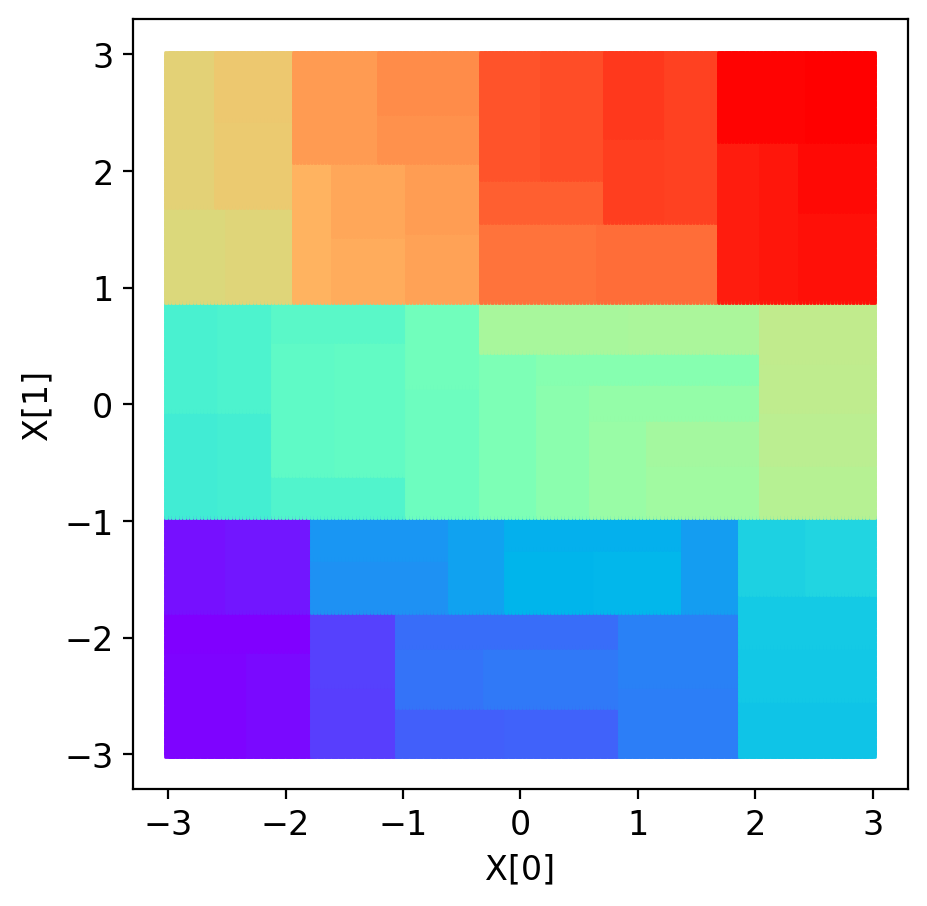

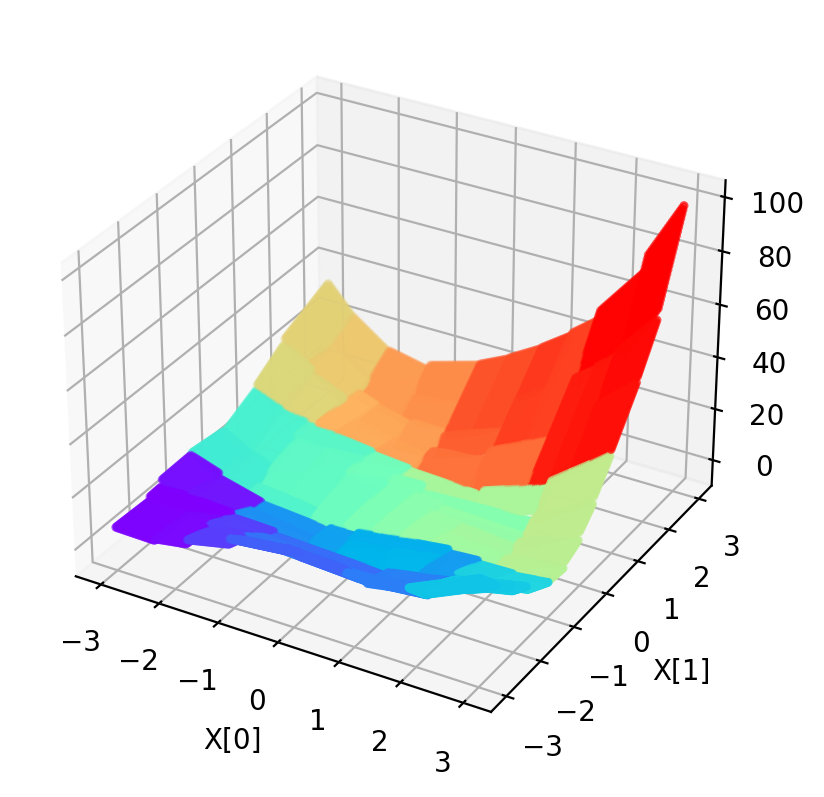

In [9]:
# Within the HyperplaneTree package, we can plot the surrogate model with the leaves in different colors
plot_surrogate_2d(model_lt, features)

Hyperparameter Sweep

That model doesn't look so bad, but let's see what we can do to improve the fit.

The main hyperparameter to control the complexity of the model is `min_samples_leaf`. By default, it is set to `0.01`, meaning each leaf must contain at least 1% of the data. Let's see what happens if we change that:

In [10]:
min_samples_leaf_vals = np.logspace(-4, -0.5, 10)
numbers_of_leaves = []
train_errors = []
test_errors = []

for min_samples_leaf in tqdm(min_samples_leaf_vals):
    model = LinearTreeRegressor(
        min_samples_leaf = min_samples_leaf,
        # disable_tqdm = True,
    )

    model.fit(train_features, train_y)
    
    numbers_of_leaves.append(model.num_leaves)

    y_pred = model.predict(features.to(torch_device)).cpu()

    train_errors.append(torch.mean(torch.abs(y_pred[train_indices] - y[train_indices])))
    test_errors.append(torch.mean(torch.abs(y_pred[test_indices] - y[test_indices])))


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/5333.333333333333 [00:00<?, ?it/s]

  0%|          | 0/5333.333333333333 [00:00<?, ?it/s]

  0%|          | 0/3336.201074400118 [00:00<?, ?it/s]

  0%|          | 0/1362.5841381159216 [00:00<?, ?it/s]

  0%|          | 0/556.5118804414252 [00:00<?, ?it/s]

  0%|          | 0/227.29273327714483 [00:00<?, ?it/s]

  0%|          | 0/92.83177667225554 [00:00<?, ?it/s]

  0%|          | 0/37.91471304812751 [00:00<?, ?it/s]

  0%|          | 0/15.48527365362254 [00:00<?, ?it/s]

  0%|          | 0/6.324555320336758 [00:00<?, ?it/s]

/Users/carolinacolombotedesco/Library/Python/3.9/lib/python/site-packages/systems2atoms/hyperplanetree/hyperplanetree/_classes.py:654: UserWarning: Training appears to have ended early.If the fit is insufficiently accurate, try increasing max_bins or max_weight.
  warnings.warn(


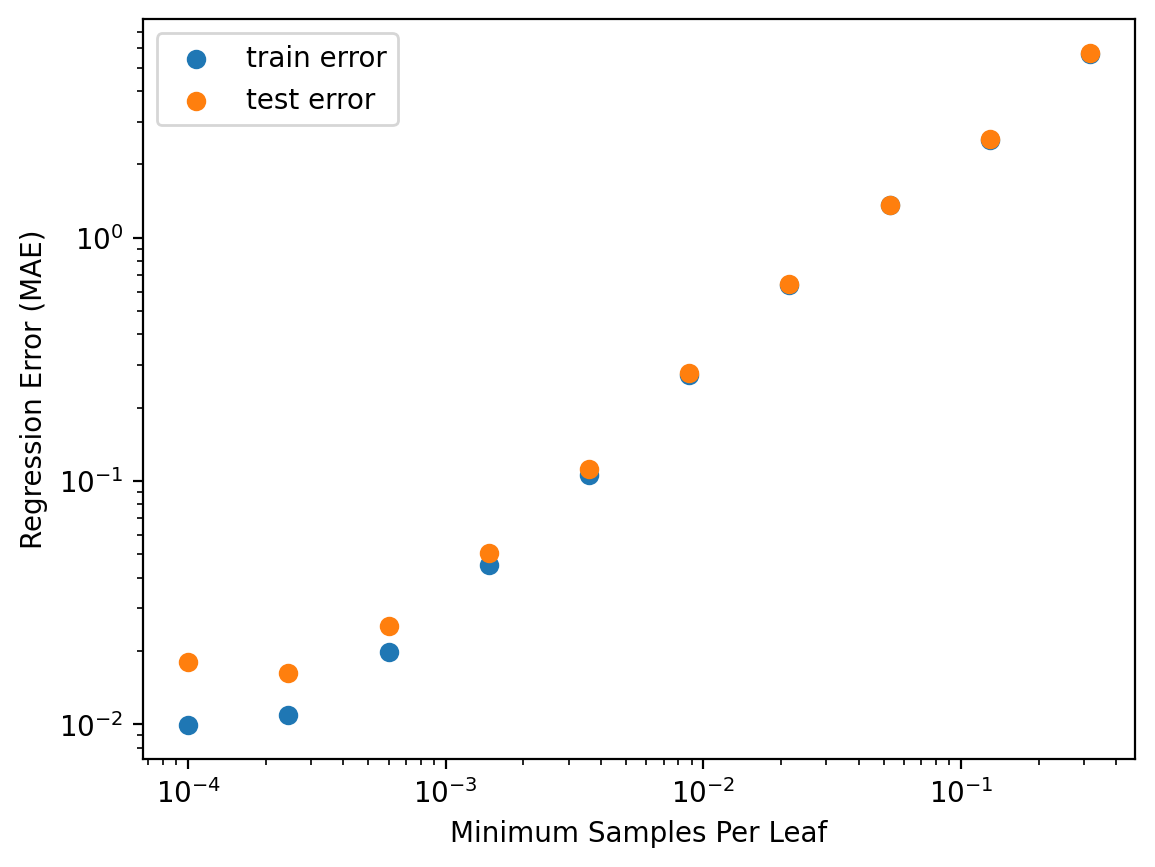

In [11]:
plt.scatter(min_samples_leaf_vals, train_errors, label = 'train error')
plt.scatter(min_samples_leaf_vals, test_errors, label = 'test error')
plt.gca().set_xscale('log')
plt.gca().set_yscale('log')

plt.xlabel('Minimum Samples Per Leaf')
plt.ylabel('Regression Error (MAE)')

plt.legend()

plt.show()

This looks like a classic hyperparameter optimization problem. Below about 0.1% minimium samples per leaf, the model starts to overfit on this data, and the test error goes up despite decreases in the train error.

Also note that the training time increases as we go to smaller and smaller numbers of samples in the leaves.

Other hyperparamaters which usually have similar behavior include:
- max_depth
- min_samples_split
- min_impurity_decrease (minimum loss improvement to execute a tree split)

For a comprehensive list of all input arguments, please see the docstring:

In [12]:
print(LinearTreeRegressor.__doc__)

A Linear Tree Regressor.

    A Linear Tree Regressor is a meta-estimator that combine the learning
    ability of Decision Tree and the predictive power of Linear Models.
    Like in tree-based algorithms, the received data are splitted according
    simple decision rules. The goodness of slits is evaluated in gain terms
    fitting linear models in each node. This implies that the models in the
    leaves are linear instead of constant approximations like in classical
    Decision Tree.

    Parameters
    ----------
    criterion : str or Callable, default = 'mae'
        Loss function to use when determining splits.
        If str, must be one of ['mae', 'rmse', 'msle', and 'max_abs']

    max_depth : int, default=torch.inf
        The maximum depth of the tree considering only the splitting nodes.
        A higher value implies a higher training time.

    min_samples_split : int or float, default=6
        The minimum number of samples required to split an internal node.
        

### Hyperplane Tree Regressor

In a Hyperplane Tree model, we can have linear combinations of the input parameters. This new possibility for the models in the leaves can be seen as the diagonal planes in the resulting figure.

Again, let's start by using the default paramater of the function within the package.

In [13]:
from systems2atoms.hyperplanetree import HyperplaneTreeRegressor

model = HyperplaneTreeRegressor()

t1 = time.time()
model.fit(train_features, train_y)
t2 = time.time()

# For evaluation, we will only use test data
y_pred = model.predict(test_features.to(torch_device)).cpu()

hyperplane_error = torch.mean(torch.abs(y_pred - test_y))
hyperplane_leaves = len(model._leaves)
hyperplane_time = t2 - t1

print(f'Model                  # Leaves      Error (MAE)    Training time (s)')
print(f'Hyperplane Tree:       {hyperplane_leaves}            {hyperplane_error:.3f}          {hyperplane_time:.2f}')

  0%|          | 0/200.0 [00:00<?, ?it/s]

Model                  # Leaves      Error (MAE)    Training time (s)
Hyperplane Tree:       74            0.196          2.81


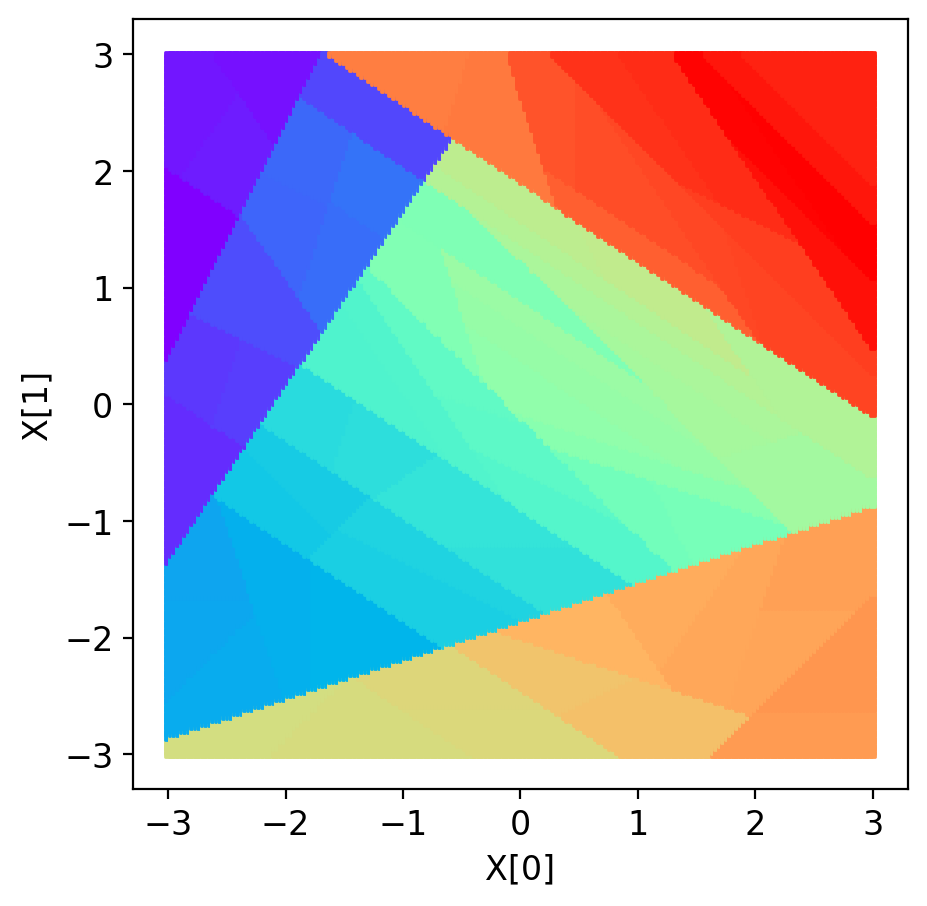

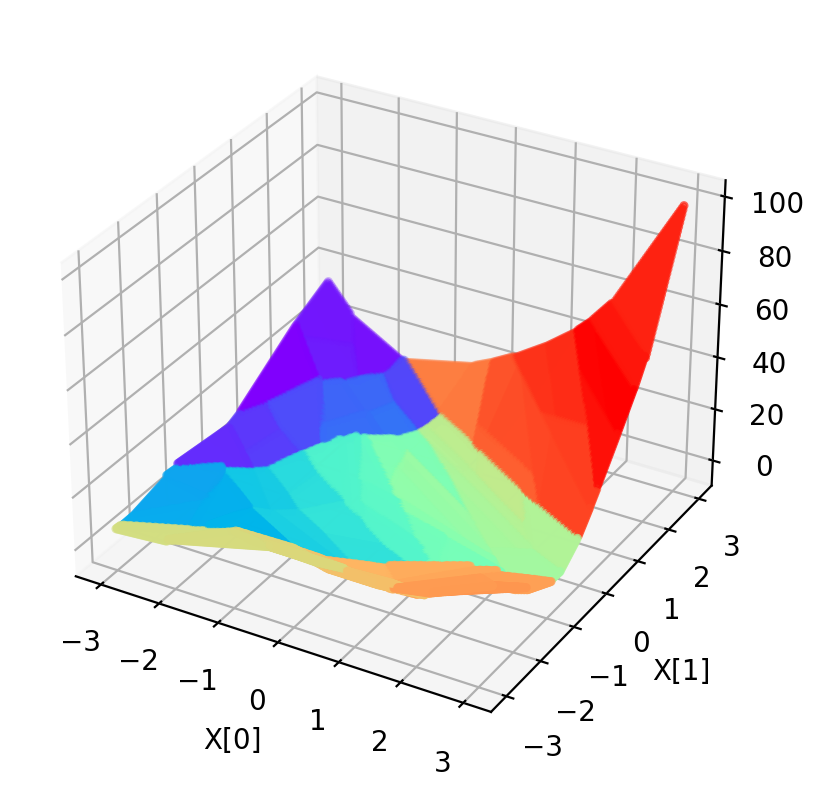

In [14]:
# Within the HyperplaneTree package, we can plot the surrogate model with the leaves in different colors
plot_surrogate_2d(model, features)

Important Hyperparameters

Two important hyperparameters to be aware of when using `HyperplaneTreeRegressor` are `max_weight` and `num_terms`. These two together control the number and complexity of the hyperplane splits. 

`num_terms` will set the maximum number of terms in the linear combination that defines the hyperplane. With two input dimensions, this should always be 2 or 1 (which should be roughly equivalent to `LinearTreeRegressor`). In higher dimensions, increasing this hyperparameter can dramatically increase the training time and memory requirements, but might lead to better accuracy without reducing actual model size.

`max_weight` will set the maximum weight of each term in the linear combination that defines the hyperplane. All integer weights from `-max_weight` to `max_weight`, inclusive will be considered. Again, increasing this hyperparameter can dramatically increase the training time and memory requirements, but might lead to better accuracy without reducing actual model size.

Notice that when `max_weight` is 1, leaf boundaries are only drawn at 90 and 45 degree angles. On the other hand, when `max_weight` is 5, boundaries can be expressed on many more angles. In this case, there is not a big difference in accuracy between the two settings.

In [15]:
max_weight_vals = np.array([1,2,3,4,5])
train_errors = []
test_errors = []

for max_weight in tqdm(max_weight_vals):
    model = HyperplaneTreeRegressor(
        max_weight = max_weight,
        disable_tqdm = False,
    )

    model.fit(train_features, train_y)
    # plot_surrogate_2d(model, features)
    
    y_pred = model.predict(features.to(torch_device)).cpu()

    train_errors.append(torch.mean(torch.abs(y_pred[train_indices] - y[train_indices])))
    test_errors.append(torch.mean(torch.abs(y_pred[test_indices] - y[test_indices])))


  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/200.0 [00:00<?, ?it/s]

  0%|          | 0/200.0 [00:00<?, ?it/s]

  0%|          | 0/200.0 [00:00<?, ?it/s]

  0%|          | 0/200.0 [00:00<?, ?it/s]

  0%|          | 0/200.0 [00:00<?, ?it/s]

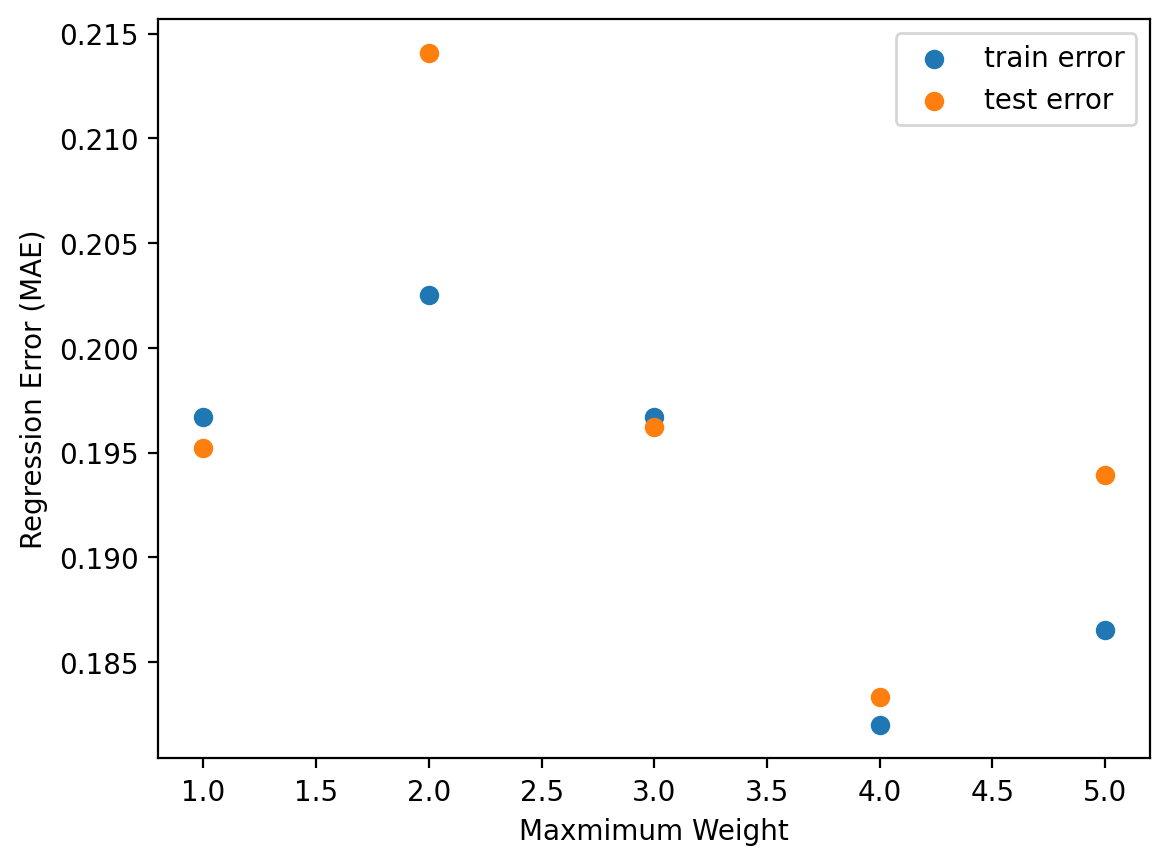

In [16]:

plt.scatter(max_weight_vals, train_errors, label = 'train error')
plt.scatter(max_weight_vals, test_errors, label = 'test error')

plt.xlabel('Maxmimum Weight')
plt.ylabel('Regression Error (MAE)')

plt.legend()

plt.show()

In [17]:
numbers_of_leaves = []
train_errors_hyperplane = []
test_errors_hyperplane = []

for min_samples_leaf in tqdm(min_samples_leaf_vals):
    model = HyperplaneTreeRegressor(
        min_samples_leaf = min_samples_leaf,
        disable_tqdm = False,
    )

    model.fit(train_features, train_y)
    
    numbers_of_leaves.append(model.num_leaves)

    y_pred = model.predict(features.to(torch_device)).cpu()

    train_errors_hyperplane.append(torch.mean(torch.abs(y_pred[train_indices] - y[train_indices])))
    test_errors_hyperplane.append(torch.mean(torch.abs(y_pred[test_indices] - y[test_indices])))

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/5333.333333333333 [00:00<?, ?it/s]

  0%|          | 0/5333.333333333333 [00:00<?, ?it/s]

  0%|          | 0/3336.201074400118 [00:00<?, ?it/s]

  0%|          | 0/1362.5841381159216 [00:00<?, ?it/s]

  0%|          | 0/556.5118804414252 [00:00<?, ?it/s]

  0%|          | 0/227.29273327714483 [00:00<?, ?it/s]

  0%|          | 0/92.83177667225554 [00:00<?, ?it/s]

  0%|          | 0/37.91471304812751 [00:00<?, ?it/s]

  0%|          | 0/15.48527365362254 [00:00<?, ?it/s]

  0%|          | 0/6.324555320336758 [00:00<?, ?it/s]

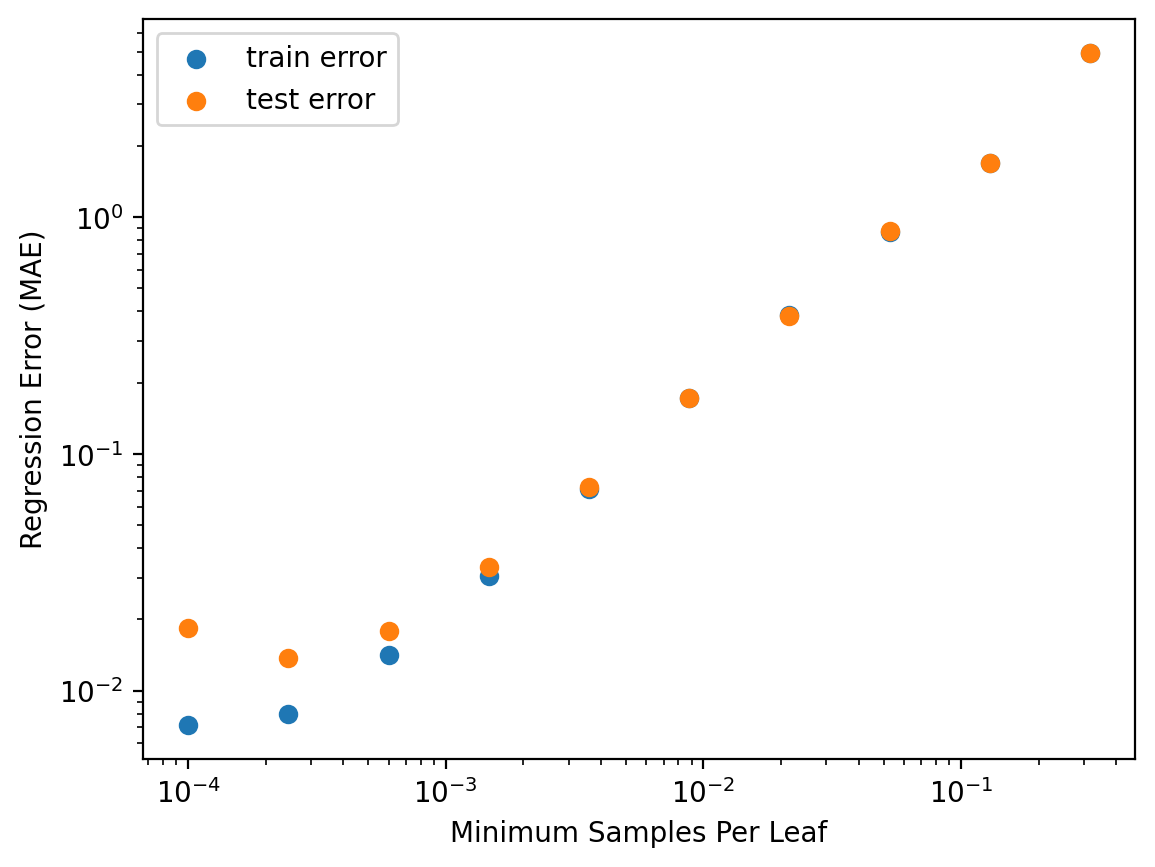

In [18]:
plt.scatter(min_samples_leaf_vals, train_errors_hyperplane, label = 'train error')
plt.scatter(min_samples_leaf_vals, test_errors_hyperplane, label = 'test error')
plt.gca().set_xscale('log')
plt.gca().set_yscale('log')

plt.xlabel('Minimum Samples Per Leaf')
plt.ylabel('Regression Error (MAE)')

plt.legend()

plt.show()

From the conclusions we can take from the hyperparameter sweep, we will train definitive LinearTree and HyperplaneTree models

  0%|          | 0/400.0 [00:00<?, ?it/s]

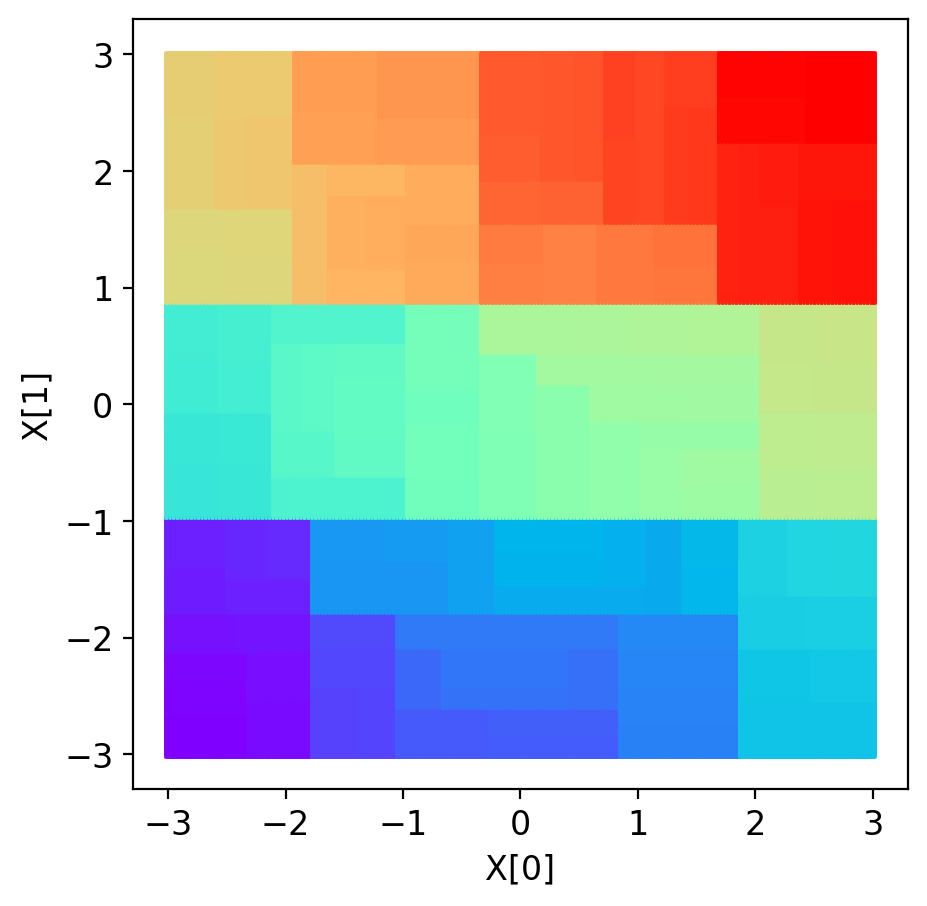

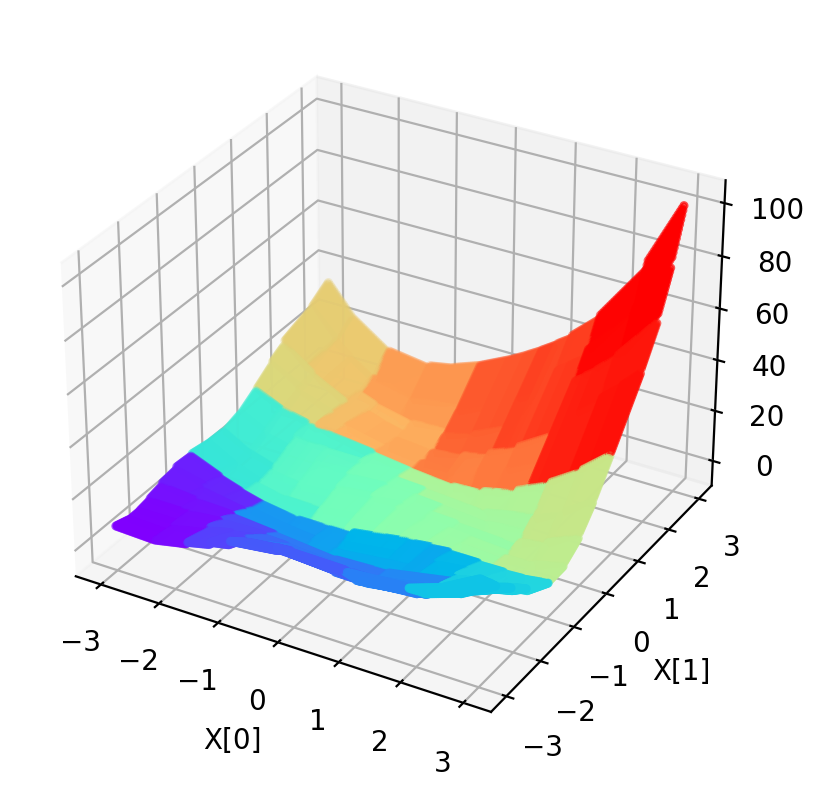

Model                  # Leaves      Error (MAE)    Training time (s)
Linear Tree:           148            0.149          1.15


In [19]:
model_lt = LinearTreeRegressor(min_samples_leaf=0.005)

t1 = time.time()
model_lt.fit(train_features, train_y)
t2 = time.time()

# For plotting purposes, we can use both train and test data
plot_surrogate_2d(model_lt, features)

# For evaluation, we will only use test data
y_pred = model_lt.predict(test_features.to(torch_device)).cpu()

linear_error = torch.mean(torch.abs(y_pred - test_y))
linear_leaves = model_lt.num_leaves
linear_time = t2 - t1

print(f'Model                  # Leaves      Error (MAE)    Training time (s)')
print(f'Linear Tree:           {linear_leaves}            {linear_error:.3f}          {linear_time:.2f}')

  0%|          | 0/400.0 [00:00<?, ?it/s]

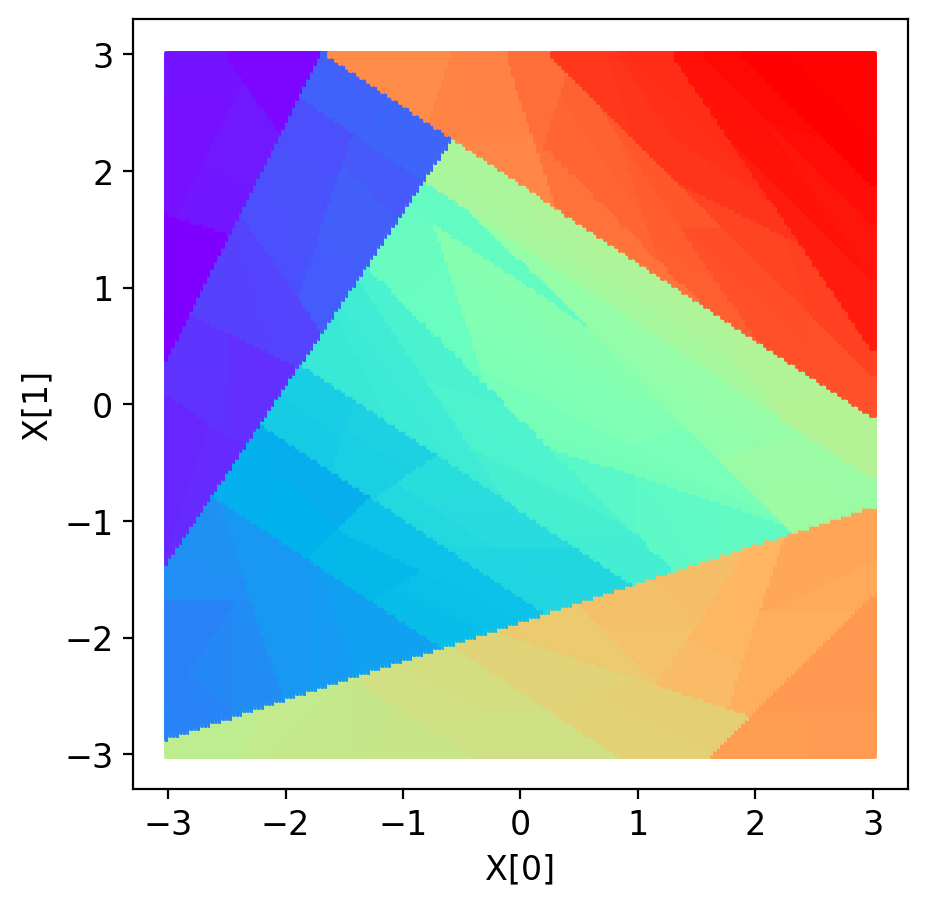

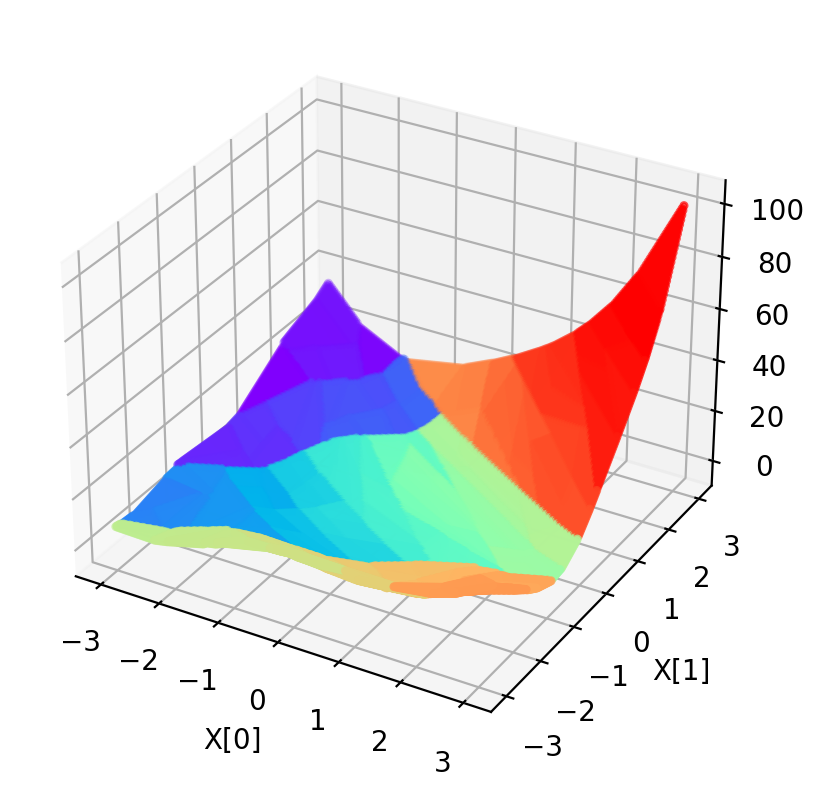

Model                  # Leaves      Error (MAE)    Training time (s)
Hyperplane Tree:       147            0.100          3.25


In [20]:
model_ht = HyperplaneTreeRegressor(min_samples_leaf=0.005)

t1 = time.time()
model_ht.fit(train_features, train_y)
t2 = time.time()

# For plotting purposes, we can use both train and test data
plot_surrogate_2d(model_ht, features)

# For evaluation, we will only use test data
y_pred = model_ht.predict(test_features.to(torch_device)).cpu()

hyperplane_error = torch.mean(torch.abs(y_pred - test_y))
hyperplane_leaves = len(model_ht._leaves)
hyperplane_time = t2 - t1

print(f'Model                  # Leaves      Error (MAE)    Training time (s)')
print(f'Hyperplane Tree:       {hyperplane_leaves}            {hyperplane_error:.3f}          {hyperplane_time:.2f}')

### Comparison of regression results

In [21]:
print(f'Model                  # Leaves      Error (MAE)    Training time (s)')

print(f'Decision Tree:         {num_leaves_dt}           {dt_error:.3f}          {dt_time:.2f}')
print(f'Linear Tree:           {linear_leaves}           {linear_error:.3f}          {linear_time:.2f}')
print(f'Hyperplane Tree:       {hyperplane_leaves}           {hyperplane_error:.3f}          {hyperplane_time:.2f}')

Model                  # Leaves      Error (MAE)    Training time (s)
Decision Tree:         198           1.077          0.05
Linear Tree:           148           0.149          1.15
Hyperplane Tree:       147           0.100          3.25


### Analyzing trees of similar sizes

Let's get a decision tree with around 150 leaves to compare with the other decision trees.

In [22]:
model_dt_150 = DecisionTreeRegressor(random_state=42,
ccp_alpha=0.01, 
# max_depth=15, 
min_samples_leaf=75, # in order to get around 150 leaves
# min_samples_split= 15,
)

t1 = time.time()
model_dt_150.fit(train_features, train_y)
t2 = time.time()

y_pred = model_dt_150.predict(test_features)

dt_error_150 = mean_absolute_error(y_pred, test_y)

num_leaves_dt_150 = model_dt_150.get_n_leaves()
dt_time_150 = t2 - t1

print(f'Model                  # Leaves      Error (MAE)    Training time (s)')
print(f'Decision Tree:           {num_leaves_dt_150}            {dt_error_150:.3f}          {dt_time_150:.2f}')

Model                  # Leaves      Error (MAE)    Training time (s)
Decision Tree:           150            1.184          0.03


In [23]:
print(f'Model                  # Leaves      Error (MAE)    Training time (s)')

print(f'Decision Tree:         {num_leaves_dt_150}           {dt_error_150:.3f}          {dt_time_150:.2f}')
print(f'Linear Tree:           {linear_leaves}           {linear_error:.3f}          {linear_time:.2f}')
print(f'Hyperplane Tree:       {hyperplane_leaves}           {hyperplane_error:.3f}          {hyperplane_time:.2f}')

Model                  # Leaves      Error (MAE)    Training time (s)
Decision Tree:         150           1.184          0.03
Linear Tree:           148           0.149          1.15
Hyperplane Tree:       147           0.100          3.25


In [24]:
!pip install git+https://github.com/emsunshine/linear-tree@main
from lineartree import LinearTreeRegressor as OriginalLinearTreeRegressor

Defaulting to user installation because normal site-packages is not writeable
  Cloning https://github.com/emsunshine/linear-tree (to revision main) to /private/var/folders/ly/14n5x27j4x58m15svpw3z2zm0000gn/T/pip-req-build-_eugu4ra
  Running command git clone --filter=blob:none --quiet https://github.com/emsunshine/linear-tree /private/var/folders/ly/14n5x27j4x58m15svpw3z2zm0000gn/T/pip-req-build-_eugu4ra
  Resolved https://github.com/emsunshine/linear-tree to commit f2c6a79fd72341cff1aed742723448e22dd0f0f6
  Preparing metadata (setup.py) ... done

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: /Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip


### Pareto plot of # of leaves and MAE

In [25]:
min_samples_leaf_vals = np.logspace(np.log(3), np.log(len(train_y)/2.01), 20, base = np.e)
print([int(x) for x in min_samples_leaf_vals])

linear_num_leaves = []
linear_train_errors = []
linear_test_errors = []

hyperplane_num_leaves = []
hyperplane_train_errors = []
hyperplane_test_errors = []

original_num_leaves = []
original_train_errors = []
original_test_errors = []

decision_num_leaves = []
decision_train_errors = []
decision_test_errors = []

# Loop for DecisionTreeRegressor
for min_samples_leaf in tqdm(min_samples_leaf_vals):
    min_samples_leaf = int(min_samples_leaf)

    model = DecisionTreeRegressor(
        min_samples_leaf = min_samples_leaf,
    )

    model.fit(train_features, train_y)

    decision_num_leaves.append(model.get_n_leaves())
    y_pred = model.predict(features)
    decision_train_errors.append(torch.mean(torch.abs(torch.tensor(y_pred[train_indices]) - y[train_indices])))
    decision_test_errors.append(torch.mean(torch.abs(torch.tensor(y_pred[test_indices]) - y[test_indices])))

# Loop for OriginalLinearTreeRegressor
for min_samples_leaf in tqdm(min_samples_leaf_vals):
    min_samples_leaf = int(min_samples_leaf)

    model = OriginalLinearTreeRegressor(
        min_samples_leaf = min_samples_leaf,
        base_estimator = LinearRegression(),
        min_impurity_decrease = -np.inf,
        max_depth = 20,
        max_bins = 50,
    )

    model.fit(train_features, train_y)

    original_num_leaves.append(len(model._leaves))
    y_pred = model.predict(features)
    original_train_errors.append(torch.mean(torch.abs(torch.tensor(y_pred[train_indices]) - y[train_indices])))
    original_test_errors.append(torch.mean(torch.abs(torch.tensor(y_pred[test_indices]) - y[test_indices])))

# Loop for LinearTreeRegressor
for min_samples_leaf in tqdm(min_samples_leaf_vals):
    min_samples_leaf = int(min_samples_leaf)

    model = LinearTreeRegressor(
        min_samples_leaf = min_samples_leaf,
        max_bins = 50,
        disable_tqdm = True,
        min_impurity_decrease = -np.inf,
    )

    model.fit(train_features, train_y)

    linear_num_leaves.append(model.num_leaves)
    y_pred = model.predict(features.to(torch_device)).cpu()
    linear_train_errors.append(torch.mean(torch.abs(y_pred[train_indices] - y[train_indices])))
    linear_test_errors.append(torch.mean(torch.abs(y_pred[test_indices] - y[test_indices])))

# Loop for HyperplaneTreeRegressor
for min_samples_leaf in tqdm(min_samples_leaf_vals):
    min_samples_leaf = int(min_samples_leaf)

    model = HyperplaneTreeRegressor(
        min_samples_leaf = min_samples_leaf,
        max_bins = 50,
        disable_tqdm = True,
        min_impurity_decrease = -np.inf,
    )

    model.fit(train_features, train_y)

    hyperplane_num_leaves.append(model.num_leaves)
    y_pred = model.predict(features.to(torch_device)).cpu()
    hyperplane_train_errors.append(torch.mean(torch.abs(y_pred[train_indices] - y[train_indices])))
    hyperplane_test_errors.append(torch.mean(torch.abs(y_pred[test_indices] - y[test_indices])))

[3, 4, 7, 11, 18, 28, 45, 70, 111, 174, 273, 430, 675, 1060, 1666, 2616, 4109, 6454, 10137, 15920]


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

Current number of nodes: 2377 | Current number of leaves: 2378
Current number of nodes: 2377 | Current number of leaves: 2378
Current number of nodes: 2376 | Current number of leaves: 2377
Current number of nodes: 2228 | Current number of leaves: 2229
Current number of nodes: 1104 | Current number of leaves: 1105
Current number of nodes: 779 | Current number of leaves: 780
Current number of nodes: 462 | Current number of leaves: 463
Current number of nodes: 328 | Current number of leaves: 329
Current number of nodes: 211 | Current number of leaves: 212
Current number of nodes: 126 | Current number of leaves: 127
Current number of nodes: 85 | Current number of leaves: 86
Current number of nodes: 54 | Current number of leaves: 55
Current number of nodes: 34 | Current number of leaves: 35
Current number of nodes: 22 | Current number of leaves: 23
Current number of nodes: 14 | Current number of leaves: 15
Current number of nodes: 8 | Current number of leaves: 9
Current number of nodes: 6 |

  0%|          | 0/20 [00:00<?, ?it/s]

/Users/carolinacolombotedesco/Library/Python/3.9/lib/python/site-packages/systems2atoms/hyperplanetree/hyperplanetree/_classes.py:654: UserWarning: Training appears to have ended early.If the fit is insufficiently accurate, try increasing max_bins or max_weight.
  warnings.warn(


  0%|          | 0/20 [00:00<?, ?it/s]

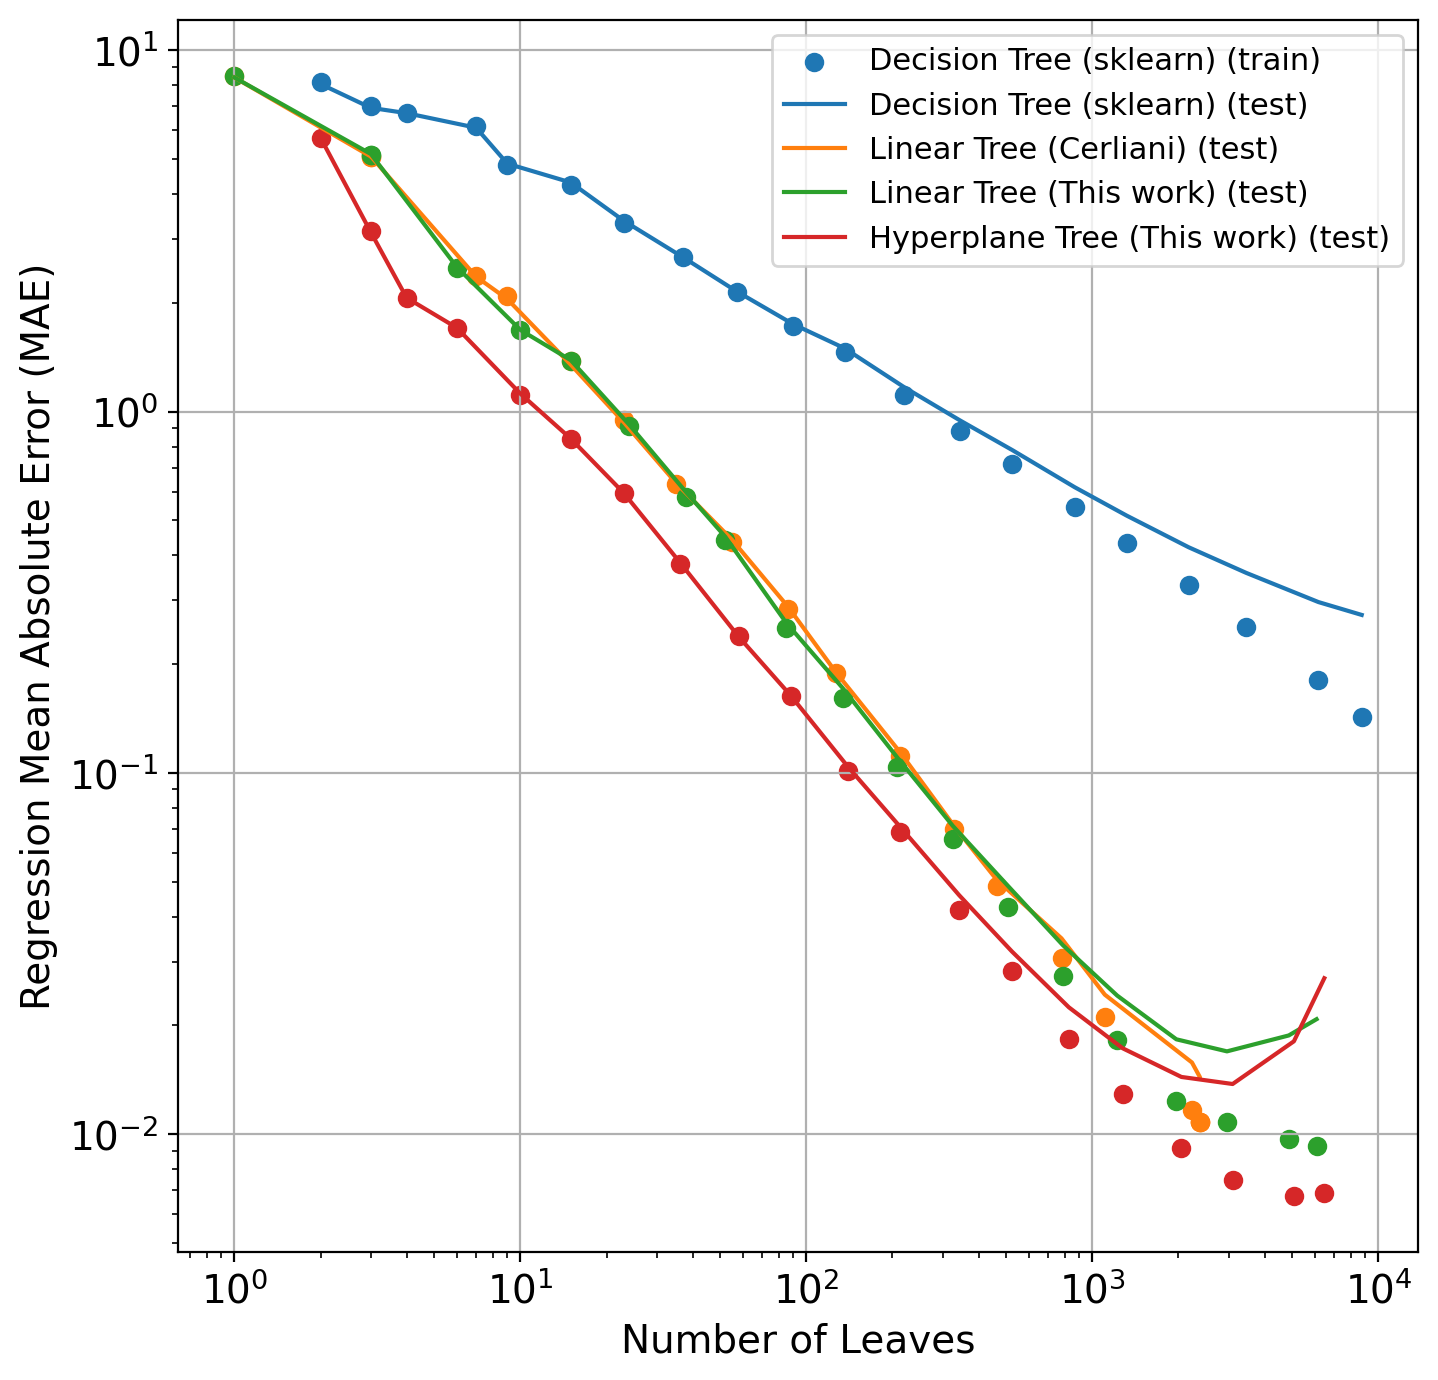

In [26]:
fig = plt.figure(figsize=(8,8))

plt.scatter(decision_num_leaves, decision_train_errors, label = 'Decision Tree (sklearn) (train)')
plt.plot(decision_num_leaves, decision_test_errors, label = 'Decision Tree (sklearn) (test)')

plt.scatter(original_num_leaves, original_train_errors)
plt.plot(original_num_leaves, original_test_errors, label = 'Linear Tree (Cerliani) (test)')


plt.scatter(linear_num_leaves, linear_train_errors)
plt.plot(linear_num_leaves, linear_test_errors, label = 'Linear Tree (This work) (test)')

plt.scatter(hyperplane_num_leaves, hyperplane_train_errors)
plt.plot(hyperplane_num_leaves, hyperplane_test_errors, label = 'Hyperplane Tree (This work) (test)')

plt.gca().set_xscale('log')
plt.gca().set_yscale('log')

plt.grid()

plt.xlabel('Number of Leaves', fontsize=14)
plt.ylabel('Regression Mean Absolute Error (MAE)', fontsize=14)
plt.legend(fontsize=11)

plt.tick_params(axis='both', which='major', labelsize=14)
plt.tick_params(axis='both', which='minor', labelsize=10)

plt.show()

fig.savefig("pareto_example_ok.png", dpi=300, format='png')



## Optimization framework using the surrogates

We now demonstrate how to embed the Hyperplane surrogate into an optimization problem in pyomo using OMLT.

In [27]:
# Identify the minimum value for respomnse and its corresponding point
y_numpy = y.cpu().numpy()  # Convert tensor to numpy array for processing
features_numpy = features.cpu().numpy()  # Convert features tensor to numpy array

min_index = y_numpy.argmin()  # Index of the minimum value
min_value = y_numpy[min_index]  # Minimum value
min_point = features_numpy[min_index]  # Corresponding point 

print(f'From the data, the minimum is at {min_point[0]}, with the value of {min_value}.')

From the data, the minimum is at -1.160804033279419, with the value of -1.9530009031295776.


### NLP with IPOPT

First, we will solve the optimization problem having our original non-linear function as objective function and different initial values. We will use the solver IPOPT, which is for use in non-linear programming.

In [28]:
import plotly.graph_objects as go
from pyomo.environ import ConcreteModel, Var, Objective, SolverFactory, cos

# Define initial guesses for the variables
initializations = [-3, -2, -1, 0, 1, 2, 3]

x1s = []
x2s = []
objs = []

# Will do optimization for each initialization
for init in initializations:
    model = ConcreteModel()

    # Define variables with bounds [-3, 3] and initial guesses
    model.x = Var(bounds=(-3, 3), initialize=init)
    model.y = Var(bounds=(-3, 3), initialize=init)

    # Define the updated coupled function
    a = (model.x - 0.5) / 1.5 + (model.y + 0.5) 
    model.obj = Objective(
        expr=a * model.x * model.y
        + a**2
        + 3 * cos(2 * a)
        + 0.2 * (model.x - 0.5)**2 * (model.y + 0.5)**2
        + 0.1 * model.x**4
        + 0.1 * model.y**4, 
    )

    # Solve the model 
    solver = SolverFactory("ipopt")
    result = solver.solve(model, tee=True)

    # Append results to lists
    x1s.append(model.x.value)
    x2s.append(model.y.value)
    objs.append(model.obj())


Ipopt 3.13.2: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes for large-scale scientific
        computation. See http://

In [29]:
# Print all the optimization results
for i, init in enumerate(initializations):
    print(f"Initialization: {init}")
    print(f"x = {x1s[i]:.4f}, y = {x2s[i]:.4f}, Objective Value = {objs[i]:.4f}")

Initialization: -3
x = -2.6913, y = -2.5521, Objective Value = 5.3755
Initialization: -2
x = -1.1349, y = -0.8985, Objective Value = -1.9458
Initialization: -1
x = -1.1349, y = -0.8985, Objective Value = -1.9458
Initialization: 0
x = -0.2830, y = 1.3123, Objective Value = -0.6546
Initialization: 1
x = -0.2830, y = 1.3123, Objective Value = -0.6546
Initialization: 2
x = -0.2830, y = 1.3123, Objective Value = -0.6546
Initialization: 3
x = -0.2830, y = 1.3123, Objective Value = -0.6546


Let's plot our NLP optimization results with different initializations using `plotly`. We can see how depending on the initialization we can find diffeent minima.

In [30]:
def generate_function_numpy(x):
    'Gnerating the exmaple function in a numpy version, for plotting.'
    x, y = x
    a = (x - 0.5) / 1.5 + (y + 0.5)  
    term1 = a * x * y  
    term2 = a**2  
    term3 = 3 * np.cos(2 * a) 
    term4 = 0.2 * (x - 0.5)**2 * (y + 0.5)**2 

    # The following terms discourage having the minimum at one of the edges
    term5 = 0.1 * (x**4)  
    term6 = 0.1 * (y**4)  

    f = term1 + term2 + term3 + term4 + term5 + term6
    return f

# Generate data for visualization
x_vals = np.linspace(-3, 3, 100)
y_vals = np.linspace(-3, 3, 100)
x_grid, y_grid = np.meshgrid(x_vals, y_vals)
z_grid = generate_function_numpy([x_grid, y_grid])

# Create a 3D surface plot using plotly 
fig = go.Figure()

# Add the surface plot
fig.add_trace(go.Surface(z=z_grid, x=x_grid, y=y_grid, colorscale="Viridis", opacity=0.8))

# Add the optimal points 
fig.add_trace(go.Scatter3d(
    x=x1s,
    y=x2s,
    z=objs,
    mode="markers",
    marker=dict(size=8, color="red", symbol="diamond"),
    name="Optimal Points",
))

fig.update_layout(
    scene=dict(
        xaxis_title="X",
        yaxis_title="Y",
        zaxis_title="Objective Value",
        aspectratio=dict(x=1, y=1, z=0.7),
    ),
    margin=dict(l=0, r=0, b=0, t=40),
)

fig.show()



### MIP with LinearTree

Now we embed the LMDT model from the lineartree package into pyomo using OMLT. The process involves the tranformation of the non-linear objective function to a piecewise linear one, the linear tree surrogate we trained. Therefore, now we solve a global optimization problem using a mixed-integer (linear) solver, like cbc or glpk.


In [31]:
from pyomo.environ import ConcreteModel, Var, Objective, SolverFactory, Constraint
from omlt import OmltBlock
from systems2atoms.hyperplanetree import HyperplaneTreeDefinition, HyperplaneTreeHybridBigMFormulation, HyperplaneTreeGDPFormulation
from omlt.linear_tree import LinearTreeGDPFormulation, LinearTreeDefinition, LinearTreeHybridBigMFormulation

# Define input bounds
input_bounds = {
    0: (-3, 3),  # Bounds for x[0]
    1: (-3, 3),  # Bounds for x[1]
}

# Define surrogate model
surrogate = LinearTreeDefinition(model_cerliani, unscaled_input_bounds=input_bounds)

x1s = []
x2s = []
objs = []
times_lt = []
results_list = []

# Initial guesses for optimization
initializations = [-3, -1, 0, 1, 3]

for init in initializations:
    m = ConcreteModel()

    m.input_0 = Var(initialize=init, bounds=(-3, 3))  
    m.input_1 = Var(initialize=init, bounds=(-3, 3))  

    # Define output variable
    m.output = Var()

    # Define objective function to minimize the surrogate's output
    m.obj = Objective(expr=m.output)

    # Add surrogate block
    m.tree_outlet = OmltBlock()

    # Key part: use a formulation to embed the surrogate model into the optimization problem
    tree_formulation = LinearTreeGDPFormulation(surrogate)
    m.tree_outlet.build_formulation(tree_formulation)

    # Add constraints to link inputs and outputs
    @m.Constraint()
    def connect_input_0(m):
        return m.input_0 == m.tree_outlet.inputs[0]  # Link x[0]

    @m.Constraint()
    def connect_input_1(m):
        return m.input_1 == m.tree_outlet.inputs[1]  # Link x[1]

    @m.Constraint()
    def connect_outputs(m):
        return m.output == m.tree_outlet.outputs[0]  # Link surrogate output to Pyomo variable

    # Solve the optimization problem
    time_1 = time.time()
    solver = SolverFactory('gurobi')  # Could also use glpk, cbc or other MIP solvers
    solver.solve(m, tee=True)
    time_2 = time.time()

    results_list.append({
        "x[0]": m.input_0.value,
        "x[1]": m.input_1.value,
        "Objective": m.output.value,
    })

    times_lt.append(time_2 - time_1)
    x1s.append(m.input_0.value)
    x2s.append(m.input_1.value)
    objs.append(m.output.value)


Set parameter Username
Set parameter LicenseID to value 2589041
Academic license - for non-commercial use only - expires 2025-11-22
Read LP format model from file /var/folders/ly/14n5x27j4x58m15svpw3z2zm0000gn/T/tmp6q6wm3oe.pyomo.lp
Reading time = 0.00 seconds
x1: 392 rows, 74 columns, 1068 nonzeros
Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (mac64[arm] - Darwin 22.1.0 22A8380)

CPU model: Apple M2 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 392 rows, 74 columns and 1068 nonzeros
Model fingerprint: 0xb7d001e6
Variable types: 10 continuous, 64 integer (64 binary)
Coefficient statistics:
  Matrix range     [1e-01, 7e+02]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 6e+02]
  RHS range        [1e+00, 9e+02]
Presolve removed 265 rows and 10 columns
Presolve time: 0.00s
Presolved: 127 rows, 64 columns, 767 nonzeros
Variable types: 3 continuous, 61 integer (61 binary)
Found heuristic solution: objective 5.2656

In [32]:
# Print the optimization results
for i, init in enumerate(initializations):
    print(f"Initialization: {init}")
    print(f"x = {x1s[i]:.4f}, y = {x2s[i]:.4f}, Objective Value = {objs[i]:.4f}")

Initialization: -3
x = -0.4975, y = -1.0100, Objective Value = -3.3471
Initialization: -1
x = -0.4975, y = -1.0100, Objective Value = -3.3471
Initialization: 0
x = -0.4975, y = -1.0100, Objective Value = -3.3471
Initialization: 1
x = -0.4975, y = -1.0100, Objective Value = -3.3471
Initialization: 3
x = -0.4975, y = -1.0100, Objective Value = -3.3471


In [33]:
# Evaluate the surrogate at the point found by the optimizer

x_opt_lt = m.input_0.value
y_opt_lt = m.input_1.value

f_opt = generate_function(torch.tensor([x_opt_lt]), torch.tensor([y_opt_lt]))
f_pred_opt = model_ht.predict(torch.tensor([[x_opt_lt, y_opt_lt]]).to(torch_device)).cpu()

print(f'Actual optimal point: {min_point[0], min_point[1]}')
print(f'Surrogate-optimal point: ({x_opt_lt}, {y_opt_lt})\n')

print(f'Original function value at this point: {f_opt.item()}')
print(f'Surrogate prediction at this point: {f_pred_opt.item()}')
print(f'Pyomo objective value at this point: {m.output.value}')

Actual optimal point: (-1.160804, -0.8894472)
Surrogate-optimal point: (-0.4974900000000058, -1.0100499999999997)

Original function value at this point: -1.1570041179656982
Surrogate prediction at this point: -1.2019503116607666
Pyomo objective value at this point: -3.347088275916583


In [35]:
# Make surrogate predictions at several points within epsilon of the optimal point
epsilon = 1e-6

for i in range(10):
    x = x_opt_lt + epsilon * torch.randn(1)
    y = y_opt_lt + epsilon * torch.randn(1)

    f = generate_function(x, y)
    f_pred = model_cerliani.predict(torch.tensor([[x_opt_lt, y_opt_lt]]).to(torch_device))


    print(f'Surrogate prediction at {x.item(), y.item()}: {f_pred.item()}')

Surrogate prediction at (-0.4974902868270874, -1.0100492238998413): -1.2866520881652832
Surrogate prediction at (-0.49748849868774414, -1.0100511312484741): -1.2866520881652832
Surrogate prediction at (-0.49749112129211426, -1.010050892829895): -1.2866520881652832
Surrogate prediction at (-0.4974888861179352, -1.0100494623184204): -1.2866520881652832
Surrogate prediction at (-0.4974881112575531, -1.010050654411316): -1.2866520881652832
Surrogate prediction at (-0.497490793466568, -1.0100493431091309): -1.2866520881652832
Surrogate prediction at (-0.4974915385246277, -1.0100501775741577): -1.2866520881652832
Surrogate prediction at (-0.497489869594574, -1.010050892829895): -1.2866520881652832
Surrogate prediction at (-0.4974910020828247, -1.0100494623184204): -1.2866520881652832
Surrogate prediction at (-0.4974890649318695, -1.0100517272949219): -1.2866520881652832


### MIP with HyperplaneTree


In [36]:
from pyomo.environ import ConcreteModel, Var, Objective, SolverFactory, Constraint
from systems2atoms.hyperplanetree import HyperplaneTreeDefinition, HyperplaneTreeHybridBigMFormulation, HyperplaneTreeGDPFormulation

# Define input bounds - Note it is a dictionaty for linear tree and a tensor for hyperplane tree
input_bounds_matrix = torch.tensor([
    [-3,3],  # Bounds for x[0]
    [-3,3]   # Bounds for x[1]
], dtype=torch.float)

# Define surrogate model
surrogate = HyperplaneTreeDefinition(model_ht, input_bounds_matrix=input_bounds_matrix)

x1s = []
x2s = []
objs = []
times_ht = []
results_list = []

# Initial guesses for optimization
initializations = [-3, -1, 0, 1, 3]


for init in initializations:
    m = ConcreteModel()

    m.input_0 = Var(initialize=init, bounds=(-3, 3))  # x[0]
    m.input_1 = Var(initialize=init, bounds=(-3, 3))  # x[1]

    # Define output variable
    m.output = Var()

    # Define objective function to minimize the surrogate's output
    m.obj = Objective(expr=m.output)

    # Add surrogate block
    m.tree_outlet = OmltBlock()

    # Key part: use a formulation to embed the surrogate model into the optimization problem
    tree_formulation = HyperplaneTreeGDPFormulation(surrogate)
    m.tree_outlet.build_formulation(tree_formulation)

    # Add constraints to link inputs and outputs
    @m.Constraint()
    def connect_input_0(m):
        return m.input_0 == m.tree_outlet.inputs[0]  # Link x[0]

    @m.Constraint()
    def connect_input_1(m):
        return m.input_1 == m.tree_outlet.inputs[1]  # Link x[1]

    @m.Constraint()
    def connect_outputs(m):
        return m.output == m.tree_outlet.outputs[0]  # Link surrogate output to Pyomo variable

    time_1 = time.time()
    solver = SolverFactory('gurobi')  # Could also use glpk, cbc or other MIP solvers
    solver.solve(m, tee=True)
    time_2 = time.time()

    results_list.append({
        "x[0]": m.input_0.value,
        "x[1]": m.input_1.value,
        "Objective": m.output.value,
    })

    times_ht.append(time_2 - time_1)
    x1s.append(m.input_0.value)
    x2s.append(m.input_1.value)
    objs.append(m.output.value)

Set parameter Username
Set parameter LicenseID to value 2589041
Academic license - for non-commercial use only - expires 2025-11-22
Read LP format model from file /var/folders/ly/14n5x27j4x58m15svpw3z2zm0000gn/T/tmplb01v2qk.pyomo.lp
Reading time = 0.01 seconds
x1: 6220 rows, 194 columns, 8334 nonzeros
Gurobi Optimizer version 12.0.0 build v12.0.0rc1 (mac64[arm] - Darwin 22.1.0 22A8380)

CPU model: Apple M2 Pro
Thread count: 12 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 6220 rows, 194 columns and 8334 nonzeros
Model fingerprint: 0xca2afffa
Variable types: 47 continuous, 147 integer (147 binary)
Coefficient statistics:
  Matrix range     [3e-02, 4e+03]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 4e+03]
  RHS range        [1e+00, 4e+03]
Presolve removed 5884 rows and 44 columns
Presolve time: 0.02s
Presolved: 336 rows, 150 columns, 2428 nonzeros
Variable types: 3 continuous, 147 integer (147 binary)
Found heuristic solution: objec

In [37]:
# Print the optimization results
for i, init in enumerate(initializations):
    print(f"Initialization: {init}")
    print(f"x = {x1s[i]:.4f}, y = {x2s[i]:.4f}, Objective Value = {objs[i]:.4f}")

Initialization: -3
x = -1.2814, y = -0.7688, Objective Value = -2.4149
Initialization: -1
x = -1.2814, y = -0.7688, Objective Value = -2.4149
Initialization: 0
x = -1.2814, y = -0.7688, Objective Value = -2.4149
Initialization: 1
x = -1.2814, y = -0.7688, Objective Value = -2.4149
Initialization: 3
x = -1.2814, y = -0.7688, Objective Value = -2.4149


In [38]:
# Evaluate the surrogate at the point found by the optimizer

x_opt = m.input_0.value
y_opt = m.input_1.value

f_opt = generate_function(torch.tensor([x_opt]), torch.tensor([y_opt]))
f_pred_opt = model_ht.predict(torch.tensor([[x_opt, y_opt]]).to(torch_device)).cpu()

print(f'Actual optimal point: {min_point[0], min_point[1]}')
print(f'Surrogate-optimal point: ({x_opt}, {y_opt})\n')

print(f'Original function value at this point: {f_opt.item()}')
print(f'Surrogate prediction at this point: {f_pred_opt.item()}')
print(f'Pyomo objective value at this point: {m.output.value}')

Actual optimal point: (-1.160804, -0.8894472)
Surrogate-optimal point: (-1.2813868899173635, -0.7688249194970351)

Original function value at this point: -1.9001643657684326
Surrogate prediction at this point: -2.1035518646240234
Pyomo objective value at this point: -2.414872416743237


In [39]:
# Make surrogate predictions at several points within epsilon of the optimal point
epsilon = 1e-6

for i in range(10):
    x = x_opt + epsilon * torch.randn(1)
    y = y_opt + epsilon * torch.randn(1)

    f = generate_function(x, y)
    f_pred = model_ht.predict(torch.tensor([[x, y]]).to(torch_device)).cpu()


    print(f'Surrogate prediction at {x.item(), y.item()}: {f_pred.item()}')

Surrogate prediction at (-1.2813867330551147, -0.7688246369361877): -2.103550910949707
Surrogate prediction at (-1.2813867330551147, -0.7688262462615967): -2.1796810626983643
Surrogate prediction at (-1.2813873291015625, -0.7688262462615967): -2.179680585861206
Surrogate prediction at (-1.281386375427246, -0.7688251733779907): -2.1035523414611816
Surrogate prediction at (-1.281386137008667, -0.7688255906105042): -2.103553295135498
Surrogate prediction at (-1.2813847064971924, -0.7688269019126892): -2.1796813011169434
Surrogate prediction at (-1.2813866138458252, -0.768824577331543): -2.103550434112549
Surrogate prediction at (-1.2813873291015625, -0.7688264846801758): -2.1796798706054688
Surrogate prediction at (-1.2813876867294312, -0.7688241004943848): -2.1035499572753906
Surrogate prediction at (-1.2813878059387207, -0.7688252329826355): -2.179682493209839


In [40]:
print(f'Model                   Optimization run time (s)')

print(f'Linear Tree:             {np.mean(times_lt):.2f}')
print(f'Hyperplane Tree:         {np.mean(times_ht):.2f}')

Model                   Optimization run time (s)
Linear Tree:             0.08
Hyperplane Tree:         0.43


Run times are fairly close even though the HyperplaneTree model is likely more complex.

Lastly, the figure below shows the hyperplane cuts and highlights the optimum point.

/var/folders/ly/14n5x27j4x58m15svpw3z2zm0000gn/T/ipykernel_17890/3829689941.py:5: UserWarning:

Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:281.)

/var/folders/ly/14n5x27j4x58m15svpw3z2zm0000gn/T/ipykernel_17890/3829689941.py:5: UserWarning:

The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3687.)



  0%|          | 0/147 [00:00<?, ?it/s]

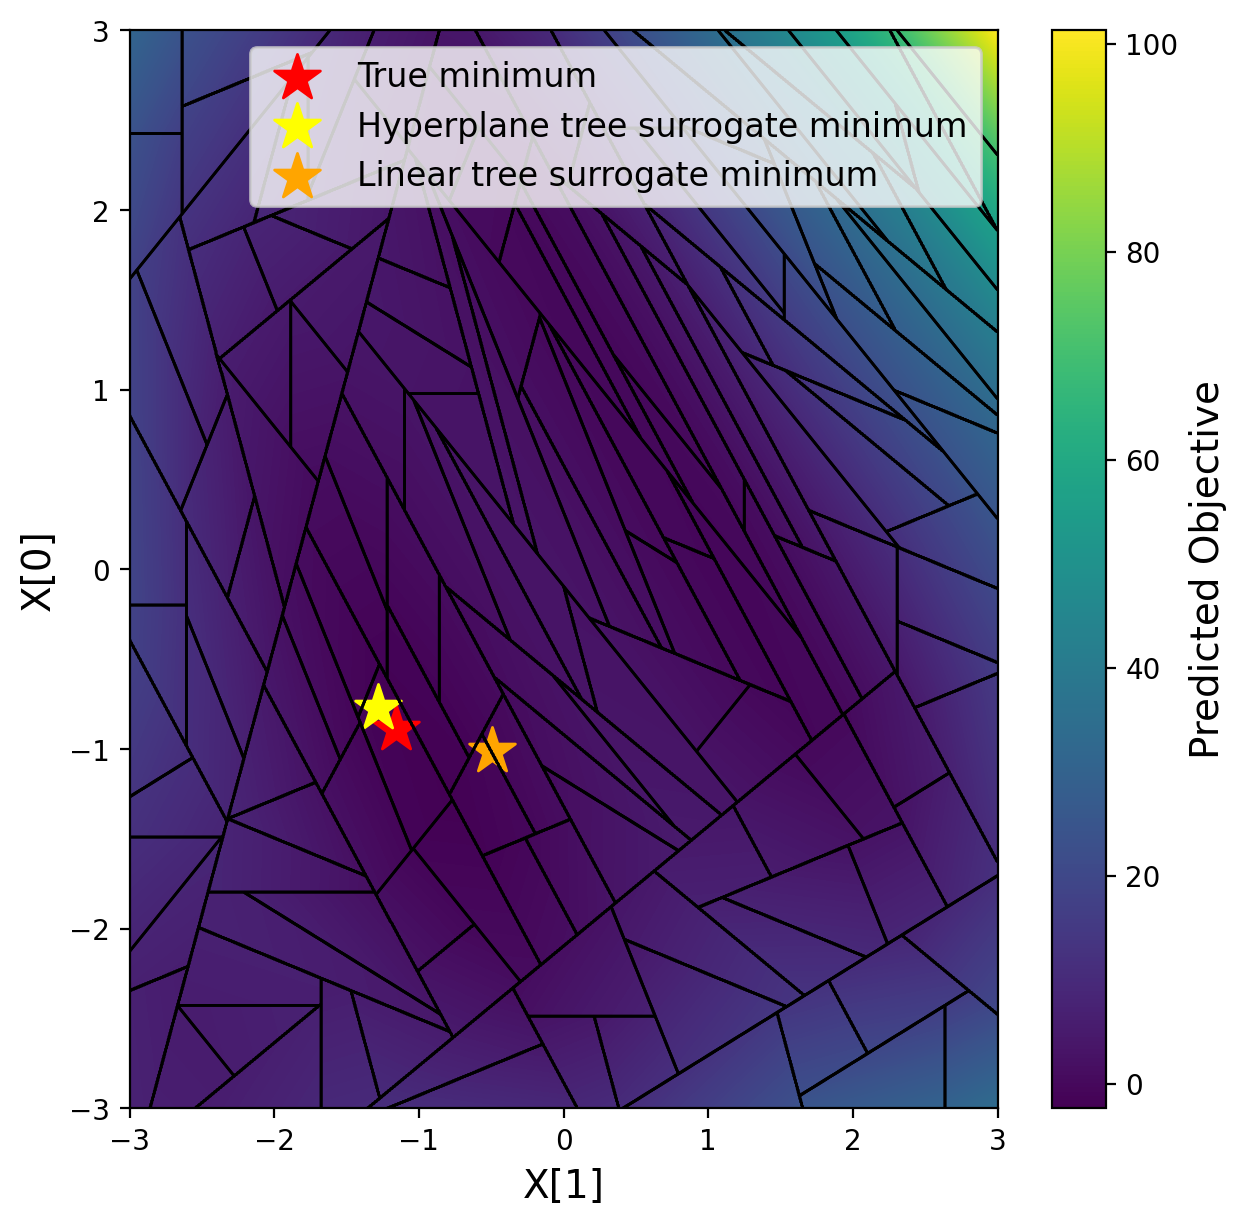

In [41]:
contour_point_density = 1000
imshow_point_density = 1000

# Define a new set of features for plotting, a linear spacing of the domain with high density
plot_features = torch.tensor(np.meshgrid(np.linspace(X0.min(), X0.max(), contour_point_density), np.linspace(X1.min(), X1.max(), contour_point_density)),dtype=torch.float).T.reshape(-1, 2)
label = model_ht.apply(plot_features.to(torch_device)).cpu().numpy()

# Make a contour plot of the labels
fig = plt.figure(figsize=(7,7))

for i in tqdm(np.unique(label)):
    plt.contour(
        plot_features[:, 1].reshape(contour_point_density, contour_point_density),
        plot_features[:, 0].reshape(contour_point_density, contour_point_density),
        (label == i).reshape(contour_point_density, contour_point_density),
        levels=[0.5],
        colors = 'black',
        linewidths = 1,
    )

# Plot the predictions
plot_features = torch.tensor(np.meshgrid(np.linspace(X0.min(), X0.max(), imshow_point_density), np.linspace(X1.min(), X1.max(), imshow_point_density)),dtype=torch.float).T.reshape(-1, 2)
y_pred = model_ht.predict(plot_features.to(torch_device)).cpu().numpy()

plt.imshow(
    y_pred.reshape(imshow_point_density, imshow_point_density),
    extent=[plot_features[:, 1].min(), plot_features[:, 1].max(), plot_features[:, 0].min(), plot_features[:, 0].max()],
    origin='lower',
    aspect='auto',
    cmap='viridis'
)

plt.colorbar().set_label('Predicted Objective', fontsize=14)

plt.xlim([plot_features[:, 1].min(), plot_features[:, 1].max()])
plt.ylim([plot_features[:, 0].min(), plot_features[:, 0].max()])

plt.ylabel('X[0]', fontsize=14)
plt.xlabel('X[1]', fontsize=14)

plt.scatter(min_point[0], min_point[1], color='red', marker='*', s=300, label='True minimum')

plt.scatter(x_opt, y_opt, color='yellow', marker='*', s=300, label='Hyperplane tree surrogate minimum')

plt.scatter(x_opt_lt, y_opt_lt, color='orange', marker='*', s=300, label='Linear tree surrogate minimum')

plt.legend(fontsize=12)
plt.show()

fig.savefig("planes_optima_ok.png", dpi=300, format='png')


In this notebook, we demonstrated step by step how to train Linear and Hyperplane Trees within the hyperplanetree package. We compared the performance and results of those with regular decision trees. We see an increase of precision and/or decrease in tree size for the HyperplaneTrees, with the tradeoff of a larger training time. 

We also showed the use of the surrogates to replace nonlinear equations in global optimization problems. This is supposed to serve as an example, since the real goal of using these surrogates is to replace nonlinear or complex constraints in larger optimization problems.